# 3D Phantom

We create a Magritte model from a snapshot of 3D Phantom hydrodynamics simulation.
The hydro model was kindly provided by Jolien Malfait.
Currently, the Phantom binary files can not yet be used directly to extract the snapshot data.
Hence we use the corresponding `.ascii` files.

## Setup

Import the required functionalty.

In [1]:
import magritte.setup as setup                # Model setup
import magritte.core  as magritte             # Core functionality
import numpy          as np                   # Data structures
import warnings                               # Hide warnings
warnings.filterwarnings('ignore')             # especially for yt
import yt                                     # 3D plotting
import os

from tqdm          import tqdm                # Progress bars
from astropy       import constants, units    # Unit conversions
from scipy.spatial import Delaunay, cKDTree   # Finding neighbors
from yt.funcs      import mylog               # To avoid yt output 
mylog.setLevel(40)                            # as error messages

Define a working directory (you will have to change this; it must be an **absolute path**).

In [2]:
wdir = "/home/frederik/Magritte-examples/Phantom_3D/"

Create the working directory.

In [3]:
!mkdir -p $wdir

Define file names.

In [4]:
input_file = os.path.join(wdir, 'model_Phantom_3D.ascii')   # Phantom snapshot
model_file = os.path.join(wdir, 'model_Phantom_3D.hdf5' )   # Resulting Magritte model
lamda_file = os.path.join(wdir, 'co.txt'                )   # Line data file

We use a snapshot and data file that can be downloaded with the following links.

In [5]:
input_link = "https://owncloud.ster.kuleuven.be/index.php/s/6mCZjZ2erTsXq5Y/download"
lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"

Dowload the snapshot and the linedata (``%%capture`` is just used to suppress the output).

In [6]:
%%capture
!wget $input_link --output-document $input_file
!wget $lamda_link --output-document $lamda_file

## Extract data

The script below extracts the required data from the snapshot `.ascii` file.

In [7]:
# Read the Phantom ascii file
(x,y,z, h, rho, vx,vy,vz, u) = np.loadtxt(input_file, skiprows=14, usecols=(0,1,2,4,5,6,7,8,9), unpack=True)

# Constants that can be read from ascii file
velocity_cte = 2.9784608e+06 * 1.0e-2
density_cte  = 5.9410314e-07
energy_cte   = 8.8712277e+12

# Exclude unphysical points
x   = x  [h>0.0]
y   = y  [h>0.0]
z   = z  [h>0.0]
rho = rho[h>0.0]
vx  = vx [h>0.0]
vy  = vy [h>0.0]
vz  = vz [h>0.0]
u   = u  [h>0.0]

# Extract the number of points
npoints = len(x)

# Convert rho (total density) to abundances
nH2 = rho * density_cte * 1.0e+6 * constants.N_A.si.value / 2.02
nCO = nH2 * 1.0e-4

# Convenience arrays
zeros = np.zeros(npoints)
ones  = np.ones (npoints)

position = np.array((x, y, z )).transpose()
velocity = np.array((vx,vy,vz)).transpose()

# Convert units
position *= constants.au.si.value                    # Convert au to m
velocity *= (velocity_cte / constants.c.cgs.value)   # cm/s to c fraction

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(position)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Compute the indices of the boundary particles of the mesh
boundary = set([])
for i in tqdm(range(delaunay.neighbors.shape[0])):
    m1  = (delaunay.neighbors[i] == -1)
    nm1 = np.sum(m1)
    if   (nm1 == 0):
        pass
    elif (nm1 == 1):
        for b in delaunay.simplices[i][m1]:
            boundary.add(b)
    elif (nm1 >= 2):
        for b in delaunay.simplices[i]:
            boundary.add(b)
boundary = list(boundary)
boundary = np.array(boundary)

# The above calculation turned out to be unsatisfactory.
# Since the outer boundary is assumed to be a sphere,
# we add all points which fall inside the boundary defined above.
b_nms = np.linalg.norm(position[boundary], axis=1)
p_nms = np.linalg.norm(position,           axis=1)
boundary = np.array([i[0] for i in np.argwhere(p_nms >= np.min(b_nms))])

# Derive temperature from internal energy (assuming adiabatic heating/cooling)
gamma = 1.2
mu    = 2.381
tmp   = mu * (gamma-1.0) * u * energy_cte * 1.00784 * (units.erg/units.g * constants.u/constants.k_B).to(units.K).value

# Cut-off temperatures below 2.725 K
tmp[tmp<2.725] = 2.725

# Define turbulence at 150 m/s
trb = (150.0/constants.c.si.value)**2 * ones

100%|████████████████████████████████████████████| 7652884/7652884 [00:44<00:00, 170825.69it/s]


## Create model

Now all data is read, we can use it to construct a Magritte model.

<div class="alert alert-warning">

Warning

Since we do not aim to do self-consistent non-LTE simulations in these examples, we only consider the first radiative transition of CO (J=1-0). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.

</div>

In [8]:
model = magritte.Model ()                              # Create model object

model.parameters.set_model_name         (model_file)   # Magritte model file
model.parameters.set_spherical_symmetry (False)        # No spherical symmetry
model.parameters.set_dimension          (3)            # This is a 3D model
model.parameters.set_npoints            (npoints)      # Number of points
model.parameters.set_nrays              (2)            # Number of rays  
model.parameters.set_nspecs             (5)            # Number of species (min. 5)
model.parameters.set_nlspecs            (1)            # Number of line species
model.parameters.set_nquads             (31)           # Number of quadrature points
model.parameters.set_pop_prec           (1.0e-6)       # Pops. convergence criterion

model.geometry.points.position.set(position)
model.geometry.points.velocity.set(velocity)

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((zeros, nCO, nH2, zeros, ones)).T
model.chemistry.species.symbol    = ['dummy0', 'CO', 'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set(tmp)
model.thermodynamics.turbulence.vturb2.set(trb)

model.parameters.set_nboundary(boundary.shape[0])
model.geometry.boundary.boundary2point.set(boundary)

model.parameters.set_nboundary(boundary.shape[0])
model.geometry.boundary.boundary2point.set(boundary)

model.geometry.rays.direction.set(np.array([[0,0,+1], [0,0,-1]]))
model.geometry.rays.weight   .set(np.array([  0.5   ,   0.5   ]))

model = setup.set_boundary_condition_CMB  (model)
model = setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
# model = setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
model = setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing parameters...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...


## Plot model

Load the data in a `yt` unstructured mesh.

In [9]:
ds = yt.load_unstructured_mesh(
    connectivity = delaunay.simplices.astype(np.int64),
    coordinates  = delaunay.points.astype(np.float64) * 100.0, # yt expects cm not m 
    node_data    = {('connect1', 'n'): nCO[delaunay.simplices].astype(np.float64)}
)

Plot a slice through the mesh orthogonal to the z-axis.


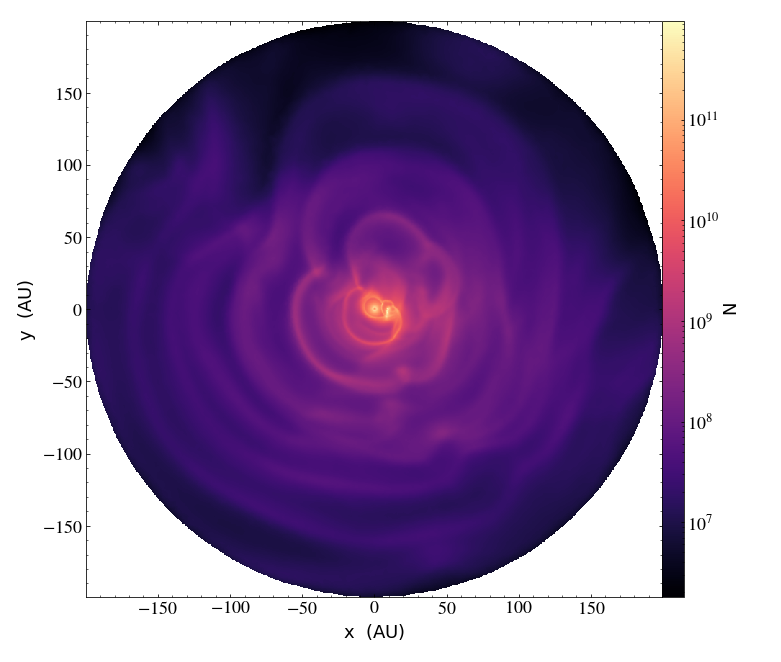

In [10]:
sl = yt.SlicePlot (ds, 'z', 'n')
sl.set_cmap       ('n', 'magma')
sl.zoom           (1.1)

Show mesh on the plot.


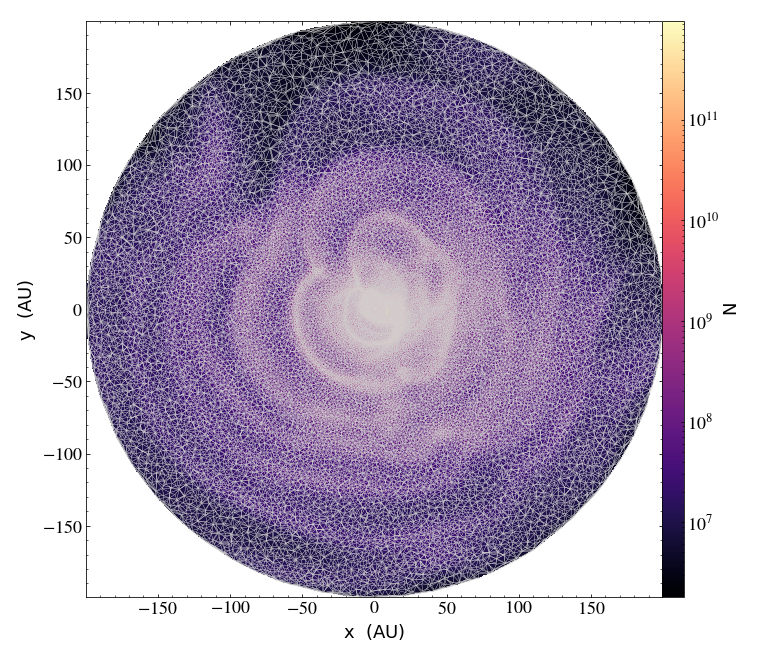

In [11]:
sl = yt.SlicePlot      (ds, 'z', 'n')
sl.set_cmap            ('n', 'magma')
sl.zoom                (1.1)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})

In the [next example](4_reduce_Phantom_3D.ipynb) we demonstrate how to reduce this model as in [De Ceuster et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020MNRAS.499.5194D/abstract).